## Fit AuotoARIMA

In [1]:
import pandas as pd


# List of file paths
file_paths = ['rnd/2013-7/392.csv', 'rnd/2013-8/392.csv', 'rnd/2013-9/392.csv']

# Initialize an empty list to store each DataFrame
dataframes = []

# Loop through each file path, load the data, and append to the list
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';\t', engine='python')  # Load each file
    dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)

# Adjusting the timestamp to reflect the correct year and month ("2013-08")

# We will recalculate the timestamp considering that each measurement was taken every 5 minutes starting from August 2013
# Assuming the first record starts at the beginning of August 2013
start_date = "2013-07-01 00:00:00"
start_timestamp = pd.to_datetime(start_date)

# Generating timestamps for each row, assuming 5-minute intervals
timestamps = [start_timestamp + pd.Timedelta(minutes=5*i) for i in range(len(data))]

# Assigning the new timestamps to the dataframe
data['ds'] = timestamps


# Creating the two univariate datasets with the corrected timestamp
cpu_usage_dataset_with_corrected_timestamp = data[['ds', 'CPU usage [%]']].copy()
cpu_usage_dataset_with_corrected_timestamp  = cpu_usage_dataset_with_corrected_timestamp.rename(columns={'CPU usage [%]': 'y'})

#Resample to hours
cpu_usage_dataset_with_corrected_timestamp['ds'] = pd.to_datetime(cpu_usage_dataset_with_corrected_timestamp['ds'])
cpu_usage_dataset_with_corrected_timestamp.set_index('ds', inplace=True)
cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.resample('H').mean()

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.reset_index()


cpu_usage_dataset_with_corrected_timestamp['unique_id'] = 'VM392'

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.tail(7*24) #Select last 7 days of data to make example faster

# Displaying the first few rows of each corrected dataset to verify
cpu_usage_dataset_with_corrected_timestamp




,ds,y,unique_id
1934,2013-09-19 14:00:00,27.776389,VM392
1935,2013-09-19 15:00:00,25.204167,VM392
1936,2013-09-19 16:00:00,27.575000,VM392
1937,2013-09-19 17:00:00,23.680556,VM392
1938,2013-09-19 18:00:00,21.361111,VM392
...,...,...,...
2097,2013-09-26 09:00:00,13.873611,VM392
2098,2013-09-26 10:00:00,15.306944,VM392
2099,2013-09-26 11:00:00,13.561111,VM392
2100,2013-09-26 12:00:00,14.638889,VM392


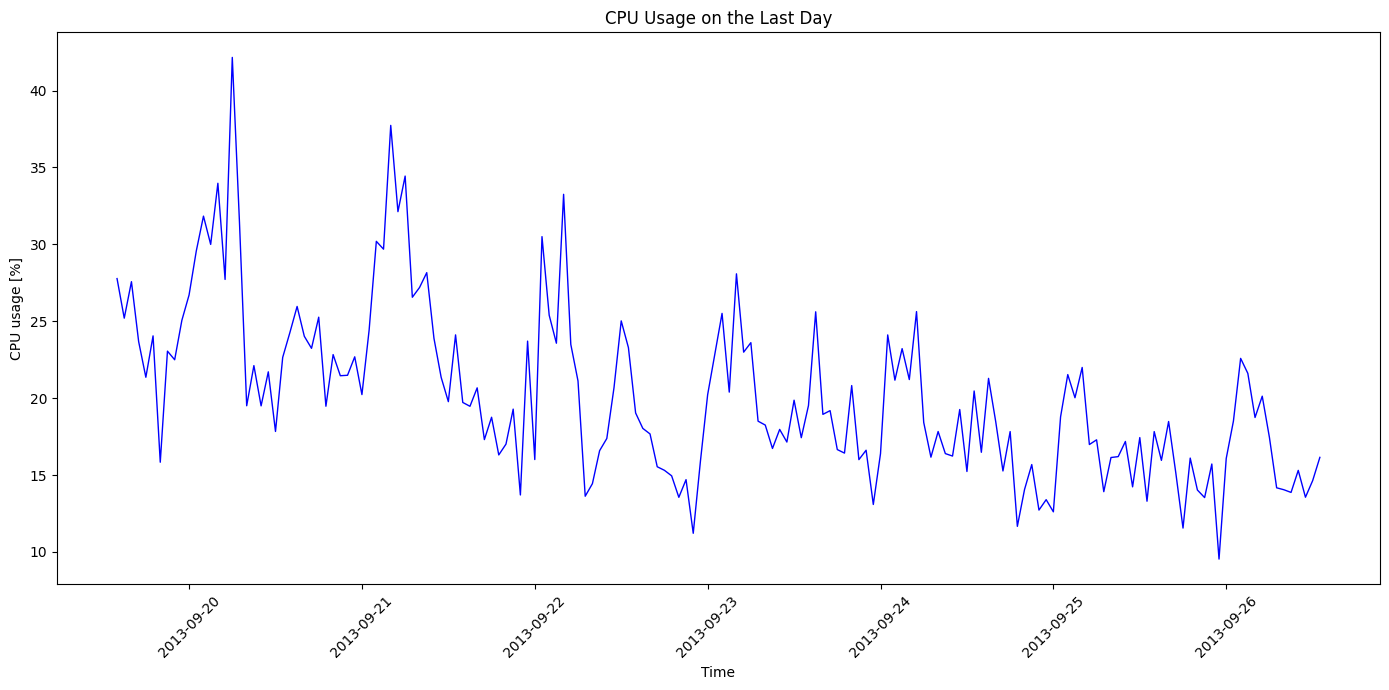

In [2]:
import matplotlib.pyplot as plt

# Plotting the CPU usage data for the last day
plt.figure(figsize=(14, 7))
plt.plot(cpu_usage_dataset_with_corrected_timestamp['ds'], cpu_usage_dataset_with_corrected_timestamp['y'], color='blue', linewidth=1)
plt.title('CPU Usage on the Last Day')
plt.xlabel('Time')
plt.ylabel('CPU usage [%]')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
from statsforecast import StatsForecast



/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from statsforecast.models import (
    AutoARIMA,
    AutoTheta,
    AutoETS,
    AutoCES,
    MSTL,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    Naive
)

models = [
    AutoARIMA(season_length=24),
    AutoTheta(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    MSTL(season_length=24),
    SeasonalNaive(season_length=24), 
    WindowAverage(window_size=24), 
    SeasonalWindowAverage(window_size=1, season_length=24),
    Naive()
]

sf = StatsForecast( 
    models=models,
    freq='H',
    fallback_model = SeasonalNaive(season_length=24),
    n_jobs=-1,
)

#forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=48, level=[90])
#forecasts_df

In [5]:
#sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [6]:
crossvaldation_df = sf.cross_validation(
    df=cpu_usage_dataset_with_corrected_timestamp,
    h=24,
    step_size=48,
    n_windows=1
)

/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
crossvaldation_df

,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive
unique_id,,,,,,,,,,,,
VM392,2013-09-25 14:00:00,2013-09-25 13:00:00,17.827778,16.294863,15.030746,14.914308,14.558580,14.601565,16.483730,16.439816,16.483730,13.301389
VM392,2013-09-25 15:00:00,2013-09-25 13:00:00,15.958333,19.407610,16.919352,16.532940,16.746859,16.906839,21.288889,16.439816,21.288889,13.301389
VM392,2013-09-25 16:00:00,2013-09-25 13:00:00,18.484722,17.691473,15.214391,14.856839,14.783504,14.937659,18.463888,16.439816,18.463888,13.301389
VM392,2013-09-25 17:00:00,2013-09-25 13:00:00,15.141666,15.294044,13.793660,13.460512,12.908437,13.033498,15.269048,16.439816,15.269048,13.301389
VM392,2013-09-25 18:00:00,2013-09-25 13:00:00,11.555555,16.913658,14.328351,13.632828,13.553157,13.450130,17.829166,16.439816,17.829166,13.301389
VM392,2013-09-25 19:00:00,2013-09-25 13:00:00,16.105556,12.849904,12.094221,11.865956,10.833764,11.080044,11.667708,16.439816,11.667708,13.301389
VM392,2013-09-25 20:00:00,2013-09-25 13:00:00,14.029166,15.492912,13.568942,12.641207,12.445768,12.431102,14.069445,16.439816,14.069445,13.301389
VM392,2013-09-25 21:00:00,2013-09-25 13:00:00,13.537500,15.664029,13.428425,12.757332,12.433367,12.691582,15.684325,16.439816,15.684325,13.301389
VM392,2013-09-25 22:00:00,2013-09-25 13:00:00,15.720139,13.535707,11.576160,11.622608,10.179573,10.527084,12.726389,16.439816,12.726389,13.301389


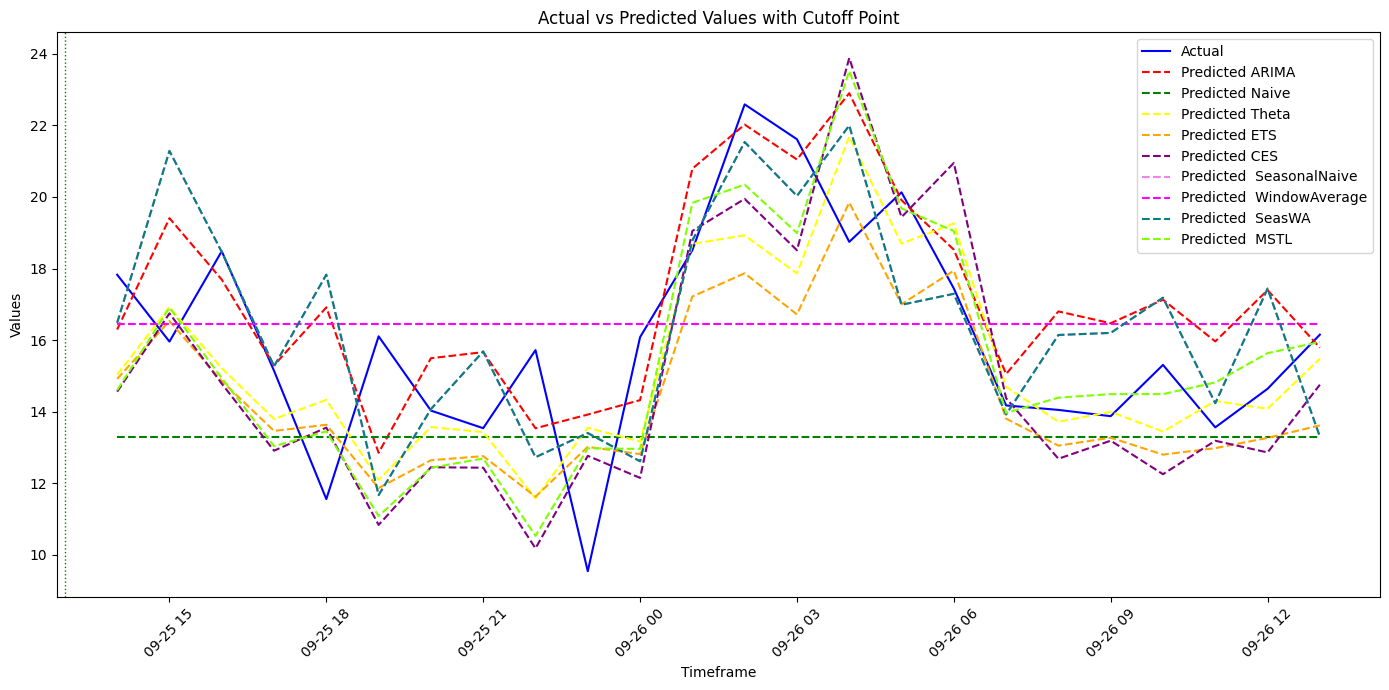

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted  MSTL', color='chartreuse', linestyle='--')

for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

# Initialize and fit the Prophet model
model = Prophet()

model.fit(cpu_usage_dataset_with_corrected_timestamp)

Importing plotly failed. Interactive plots will not work.
21:47:49 - cmdstanpy - INFO - Chain [1] start processing
21:47:49 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
df_cv = cross_validation(model, horizon='1 days', initial='5 days')

  0%|          | 0/2 [00:00<?, ?it/s]

21:49:05 - cmdstanpy - INFO - Chain [1] start processing
21:49:05 - cmdstanpy - INFO - Chain [1] done processing
21:49:05 - cmdstanpy - INFO - Chain [1] start processing
21:49:05 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
pd.set_option('display.max_rows', 97)
df_cv = df_cv.sort_values(by='ds')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-09-25 02:00:00,20.780907,17.004961,25.121566,21.534722,2013-09-25 01:00:00
1,2013-09-25 03:00:00,22.751960,18.673663,26.922857,20.029563,2013-09-25 01:00:00
2,2013-09-25 04:00:00,23.332417,18.951113,27.351474,21.998611,2013-09-25 01:00:00
3,2013-09-25 05:00:00,22.245623,18.435578,26.720970,16.987356,2013-09-25 01:00:00
4,2013-09-25 06:00:00,19.875024,15.706422,24.120735,17.293651,2013-09-25 01:00:00
5,2013-09-25 07:00:00,17.087943,12.907531,21.297656,13.922222,2013-09-25 01:00:00
6,2013-09-25 08:00:00,14.801472,10.636439,19.228546,16.143056,2013-09-25 01:00:00
7,2013-09-25 09:00:00,13.568961,9.358454,17.451245,16.200694,2013-09-25 01:00:00
8,2013-09-25 10:00:00,13.421471,9.355789,17.470386,17.186111,2013-09-25 01:00:00
9,2013-09-25 11:00:00,13.996021,10.095556,18.125499,14.236111,2013-09-25 01:00:00


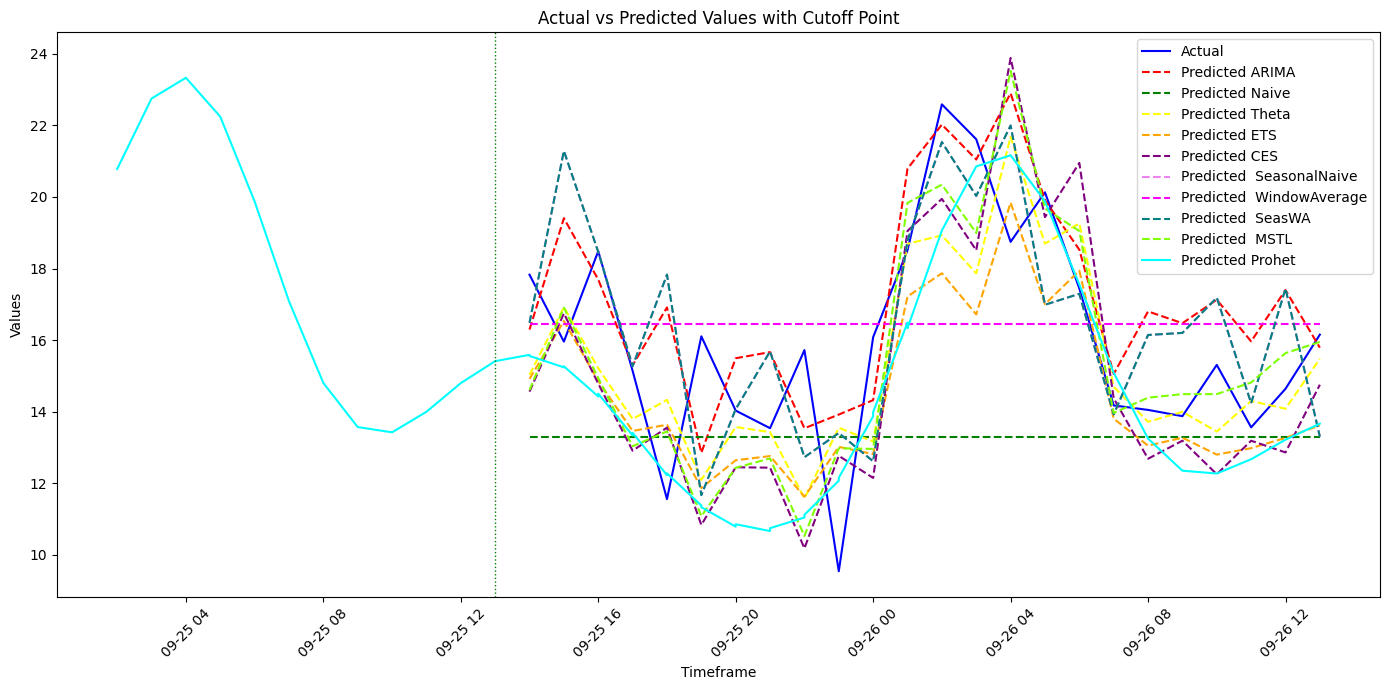

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted  MSTL', color='chartreuse', linestyle='--')

plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prohet', color='cyan', linestyle='-')


for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [14]:
crossvaldation_df = crossvaldation_df.reset_index()
crossvaldation_df['prophet'] = df_cv['yhat']
crossvaldation_df

,unique_id,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet
0,VM392,2013-09-25 14:00:00,2013-09-25 13:00:00,17.827778,16.294863,15.030746,14.914308,14.558580,14.601565,16.483730,16.439816,16.483730,13.301389,20.780907
1,VM392,2013-09-25 15:00:00,2013-09-25 13:00:00,15.958333,19.407610,16.919352,16.532940,16.746859,16.906839,21.288889,16.439816,21.288889,13.301389,22.751960
2,VM392,2013-09-25 16:00:00,2013-09-25 13:00:00,18.484722,17.691473,15.214391,14.856839,14.783504,14.937659,18.463888,16.439816,18.463888,13.301389,23.332417
3,VM392,2013-09-25 17:00:00,2013-09-25 13:00:00,15.141666,15.294044,13.793660,13.460512,12.908437,13.033498,15.269048,16.439816,15.269048,13.301389,22.245623
4,VM392,2013-09-25 18:00:00,2013-09-25 13:00:00,11.555555,16.913658,14.328351,13.632828,13.553157,13.450130,17.829166,16.439816,17.829166,13.301389,19.875024
5,VM392,2013-09-25 19:00:00,2013-09-25 13:00:00,16.105556,12.849904,12.094221,11.865956,10.833764,11.080044,11.667708,16.439816,11.667708,13.301389,17.087943
6,VM392,2013-09-25 20:00:00,2013-09-25 13:00:00,14.029166,15.492912,13.568942,12.641207,12.445768,12.431102,14.069445,16.439816,14.069445,13.301389,14.801472
7,VM392,2013-09-25 21:00:00,2013-09-25 13:00:00,13.537500,15.664029,13.428425,12.757332,12.433367,12.691582,15.684325,16.439816,15.684325,13.301389,13.568961
8,VM392,2013-09-25 22:00:00,2013-09-25 13:00:00,15.720139,13.535707,11.576160,11.622608,10.179573,10.527084,12.726389,16.439816,12.726389,13.301389,13.421471
9,VM392,2013-09-25 23:00:00,2013-09-25 13:00:00,9.539236,13.918601,13.549335,13.016324,12.765429,12.976596,13.402778,16.439816,13.402778,13.301389,13.996021


In [15]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [16]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet,best_model
unique_id,,,,,,,,,,,
VM392,6.007667,5.571093,6.867131,8.132349,6.335803,7.659645,8.90235,7.659645,16.193548,19.493375,AutoTheta
